<a href="https://colab.research.google.com/github/dlevonian/nyu_cola/blob/master/bert_cola_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Objective

Tagging the NYU's [Corpus of Linguistic Acceptability (CoLA)](https://nyu-mll.github.io/CoLA/) is one of the GLUE challenges.
The CoLA dataset (and associated challenge) was proposed in May 2018 by [Warstadt et al.](https://arxiv.org/pdf/1805.12471.pdf) and was designed to include 3 types of violations:
- Morphological Violation (*Maryann should leaving.)
- Syntactic Violation (*What did Bill buy potatoes and?)
- Semantic Violation (*Kim persuaded it to rain.)

There are approximately 8.5K training samples where each sentence is tagged by a Boolean label denoting whether the sentence is grammatical or not. The challenge is evaluated on the test set of about 500 samples.

This notebook applies Google's BERT to the CoLA challenge:
- transformers have achieved [SOTA results](https://gluebenchmark.com/leaderboard) across a broad range of NLP tasks including the GLUE challenges
- our objective is to build an end-to-end TensorFlow pipeline leveraging [TF Hub BERT collection](https://tfhub.dev/google/collections/bert/1)



### Imports

In [1]:
# make sure nightly builds are installed to use official.nlp modules
!pip install tf-nightly
!pip install -q tf-models-nightly

     |████████████████████████████████| 324.8MB 42kB/s 
     |████████████████████████████████| 460kB 53.6MB/s 
     |████████████████████████████████| 6.7MB 53.9MB/s 
     |████████████████████████████████| 880kB 5.2MB/s 
     |████████████████████████████████| 358kB 31.0MB/s 
     |████████████████████████████████| 174kB 22.6MB/s 
     |████████████████████████████████| 1.1MB 36.6MB/s 
     |████████████████████████████████| 102kB 13.5MB/s 
     |████████████████████████████████| 36.4MB 82kB/s 
     |████████████████████████████████| 296kB 56.4MB/s 


In [3]:
import numpy as np
import pandas as pd

import math
import time

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [4]:
import tensorflow as tf
import tensorflow_hub as hub
# %load_ext tensorboard

from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences

import official.nlp.bert.tokenization as tokenization
import official.nlp.optimization as optimization

print("TF version: ", tf.__version__)
print("Hub version: ", hub.__version__)
print('GPU is available' if tf.config.experimental.list_physical_devices('GPU') else 'CPU')

TF version:  2.4.0-dev20200726
Hub version:  0.8.0
GPU is available


In [7]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
path = '/content/drive/My Drive/chatbot/'

Mounted at /content/drive


### Load NYU CoLA dataset

In [8]:
train_df = pd.read_csv(path+'cola_data/in_domain_train.tsv',sep="\t", header=None)
print(train_df.shape)
print(train_df.iloc[:,1].mean())
train_df.sample(5)

(8551, 4)
0.704362062916618


,0,1,2,3
7636,sks13,1,NaN,Susan hopes to sleep.
5905,c_13,1,NaN,That Bill loves chocolate is likely.
1327,r-67,1,NaN,Please make yourself comfortable and I'll wash...
4572,ks08,0,*,"John seems fond of ice cream, and Bill seems, ..."
4983,ks08,1,NaN,We just finished the final exam the result of ...


In [9]:
val_df = pd.read_csv(path+'cola_data/in_domain_dev.tsv',sep="\t", header=None)
print(val_df.shape)
print(val_df.iloc[:,1].mean())
val_df.sample(5)

(527, 4)
0.6925996204933587


,0,1,2,3
109,r-67,1,NaN,"Sally is tall, and may be blond, and Sheila is..."
504,ad03,0,*,I thought he liked myself
411,m_02,1,NaN,He left the train with somebody else's wallet ...
48,bc01,1,NaN,I remembered having kissed Mary.
198,l-93,1,NaN,Cynthia nibbled on the carrot .


In [10]:
test_df = pd.read_csv(path+'cola_data/kaggle_in_domain_test.tsv',sep="\t", index_col='Id')
print(test_df.shape)
test_df.sample(5)

(530, 1)


,Sentence
Id,
473,John liked Mary.
276,There seem to be no student absent.
150,This meat cuts itself.
470,Does John go to school?
115,The cops spoke to the janitor about that robbe...


### Load BERT from TF Hub

Use the light BERT (~400 Mb):  [bert_en_uncased_L-12_H-768_A-*12*](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2)



In [11]:
tic = time.time()
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2",  
                            name = 'bert_layer',
                            trainable=True)
toc = time.time()
print(f'done in {toc-tic:.1f} sec')

done in 10.6 sec


In [12]:
bert_layer.get_config()

{'dtype': 'float32',
 'handle': 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2',
 'name': 'bert_layer',
 'trainable': True}

BERT produces two outputs: 
- a pooled_output of shape [batch_size, 768] with representations for the entire input sequences 
- a sequence_output of shape [batch_size, max_seq_length, 768] with representations for each input token (in context)

In [13]:
# dir(bert_layer)

### Tokenization

In [14]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)
# dir(tokenizer)

In [15]:
s = 'Implement CoLA classification with fine-tuning BERT'
tokens = tokenizer.tokenize(s)
print(tokens)
ids = tokenizer.convert_tokens_to_ids(tokens)
print(ids)


['implement', 'cola', 'classification', 'with', 'fine', '-', 'tuning', 'bert']
[10408, 15270, 5579, 2007, 2986, 1011, 17372, 14324]


In [16]:
def encode_sentence(s):
    # any input sequence in BERT must start with [CLS] token
    # the first sentence (whether in pairs or standalone) must end with [SEP]
    return (tokenizer.convert_tokens_to_ids(['[CLS]']) + 
            tokenizer.convert_tokens_to_ids(tokenizer.tokenize(s)) + 
            tokenizer.convert_tokens_to_ids(['[SEP]']))

In [17]:
def produce_ids(df):
    ids=[]
    for s in df.iloc[:,-1]:
        ids.append(encode_sentence(s))
    return ids

train_ids, val_ids, test_ids = map(produce_ids, [train_df, val_df, test_df])    

print(f'max len train =', max(map(len, train_ids)))
print(f'max len val =', max(map(len, val_ids)))
print(f'max len test =', max(map(len, test_ids)))

max len train = 47
max len val = 31
max len test = 38


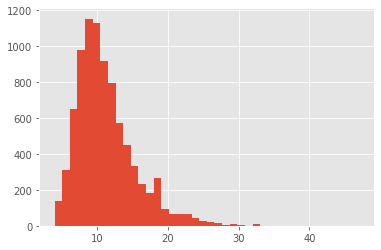

In [18]:
plt.hist(list(map(len, train_ids)),bins=40)
plt.show()

In [19]:
# Pad zeros to MAX_LEN
MAX_LEN = 47
pad_fn = lambda ids: pad_sequences(ids, maxlen=MAX_LEN, dtype="long", value=0, padding="post")
train_ids, val_ids, test_ids = map(pad_fn, [train_ids, val_ids, test_ids])

train_ids[:2]

array([[  101,  2256,  2814,  2180,  1005,  1056,  4965,  2023,  4106,
         1010,  2292,  2894,  1996,  2279,  2028,  2057, 16599,  1012,
          102,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0],
       [  101,  2028,  2062, 18404,  2236,  3989,  1998,  1045,  1005,
         1049,  3228,  2039,  1012,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0]])

In [20]:
# Produce BERT input masks indicating relevant tokens 
mask_fn = np.vectorize(lambda arr: int(arr>0))
train_mask, val_mask, test_mask = map(mask_fn, [train_ids, val_ids, test_ids])

train_mask[:2]

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0]])

### Produce Datasets

In [21]:
# put everything together in one function, produce shuffled, batched TF dataset

BATCH_SIZE=128

def bert_dataset(df, max_len=MAX_LEN, batch_size=BATCH_SIZE):
    """
    Produce TF dataset from the input dataframe
    The convention for the input df is that labels are in column 1, text in column -1
    """
    input_word_ids=[]
    for sentence in df.iloc[:,-1]:
        input_word_ids.append(encode_sentence(sentence))
    input_word_ids = pad_sequences(input_word_ids, maxlen=max_len, dtype="long", value=0, padding="post")

    input_mask = np.vectorize(lambda arr: int(arr>0))(input_word_ids)
    # BERT needs the 'segment ids' element. For single-sentence tasks such as classification, supply zeros.
    input_segment_ids = np.zeros_like(input_mask)

    inputs = (input_word_ids, input_mask, input_segment_ids)

    labels = df.iloc[:,1].values

    dataset = tf.data.Dataset.from_tensor_slices((inputs, labels))
    dataset = dataset.shuffle(1024).batch(batch_size) 
    dataset = dataset.cache()
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    
    return dataset

In [22]:
train_dataset = bert_dataset(train_df)
val_dataset   = bert_dataset(val_df)

# verify the dataset element
print(train_dataset.element_spec )
next(iter(train_dataset))


((TensorSpec(shape=(None, 47), dtype=tf.int64, name=None), TensorSpec(shape=(None, 47), dtype=tf.int64, name=None), TensorSpec(shape=(None, 47), dtype=tf.int64, name=None)), TensorSpec(shape=(None,), dtype=tf.int64, name=None))


((<tf.Tensor: shape=(128, 47), dtype=int64, numpy=
  array([[ 101, 2023, 2311, ...,    0,    0,    0],
         [ 101, 2984, 2187, ...,    0,    0,    0],
         [ 101, 2065, 2002, ...,    0,    0,    0],
         ...,
         [ 101, 2023, 2003, ...,    0,    0,    0],
         [ 101, 3071, 2040, ...,    0,    0,    0],
         [ 101, 2054, 2079, ...,    0,    0,    0]])>,
  <tf.Tensor: shape=(128, 47), dtype=int64, numpy=
  array([[1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         ...,
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0]])>,
  <tf.Tensor: shape=(128, 47), dtype=int64, numpy=
  array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]])>),
 <tf.Tensor: shape=(128,), dtype=int64, numpy=
 array([1, 1, 1, 1, 1, 0, 1,

### BERT model

In [23]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.initializers import Constant

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Precision, Recall, AUC

import tensorflow.keras.backend as K

Helper functions

In [24]:
def MCC(y_true, y_pred):
    # implement Matthews correlation coefficient
    y_true_pos = K.round(K.clip(y_true, 0, 1)) 
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_true_neg, y_pred_neg = 1-y_true_pos, 1-y_pred_pos

    tp = K.sum(y_true_pos * y_pred_pos)
    tn = K.sum(y_true_neg * y_pred_neg)
    fp = K.sum(y_true_neg * y_pred_pos)
    fn = K.sum(y_true_pos * y_pred_neg)

    return (tp*tn - fp*fn)/(K.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)) + K.epsilon())


In [25]:
def plot_training(history):
    f,axes = plt.subplots(1, 2, figsize=(12, 4))
    ax0,ax1=axes[0],axes[1]
    epochs = np.arange(1,EPOCHS+1)

    ax0.plot(epochs, history.history['MCC'], label='MCC train') 
    ax0.plot(epochs, history.history['val_MCC'], label='MCC val') 
    ax0.set_title('Matthews correlation')
    ax0.set_ylim(0,1.1)
    ax0.legend()

    ax1.plot(epochs, history.history['precision'], label='AUC train') 
    ax1.plot(epochs, history.history['val_precision'], label='AUC val') 
    ax1.set_title('AUC')
    ax1.set_ylim(0,1.1)
    ax1.legend()

    plt.show()

Build the model using BERT layer

In [55]:
input_word_ids = Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_word_ids")
input_mask     = Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_mask")
segment_ids    = Input(shape=(MAX_LEN,), dtype=tf.int32, name="segment_ids")

inputs = [input_word_ids, input_mask, segment_ids]

# BERT has 2 outputs - pooled_output, sequence_output
# For classification purposes, use only the pooled_output (H dimension of the first [CLS] token)
x, _ = bert_layer(inputs)

dropout_rate = 0.1
x = Dropout(dropout_rate)(x)

# initial bias for the classifier to reflect class imbalance
class_bias = np.log(1/(1-train_df.iloc[:,1].mean())-1)
output = Dense(1, activation='sigmoid', bias_initializer=Constant(class_bias))(x)

model = Model(inputs, output)

In [56]:
model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 47)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 47)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 47)]         0                                            
__________________________________________________________________________________________________
bert_layer (KerasLayer)         [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

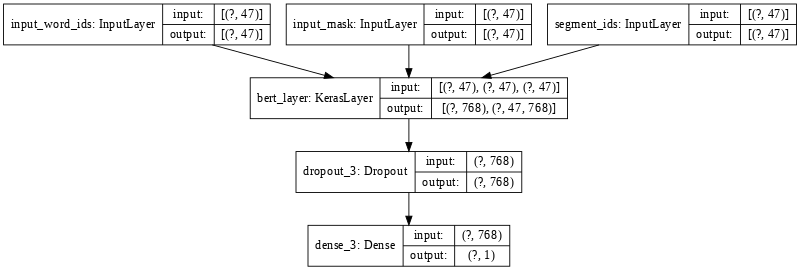

In [57]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

In [58]:
# verify the proper functioning of the computational graph
tic=time.time()

sample_input = next(iter(train_dataset))
sample_output = model(sample_input)

toc=time.time()
print(f'done in {toc-tic:.1f} sec')
print(sample_output.shape)


done in 0.0 sec
(128, 1)


In [59]:
EPOCHS = 10

In [60]:
# set up the optimizer
train_data_size = train_df.shape[0]
steps_per_epoch = int(train_data_size / BATCH_SIZE)
num_train_steps = steps_per_epoch * EPOCHS
warmup_steps = 0 #int(EPOCHS * train_data_size * 0.1 / BATCH_SIZE)

bert_optimizer = optimization.create_optimizer(init_lr=1e-4, 
                                        num_train_steps=num_train_steps, 
                                        num_warmup_steps=warmup_steps)

In [61]:
# Use either bert_optimizer or Adam with flat schedule (e.g. Adam(1e-5))
model.compile(optimizer=bert_optimizer,
              loss=BinaryCrossentropy(),
              metrics=[MCC, Precision(name='precision')], 
              )


In [62]:
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    verbose=1,

    # callbacks = [early_stopping],
    validation_data=val_dataset)

Epoch 1/10
67/67 [==============================] - 52s 776ms/step - loss: 0.4128 - MCC: 0.5851 - precision: 0.8482 - val_loss: 0.4619 - val_MCC: 0.5832 - val_precision: 0.8387
Epoch 2/10
67/67 [==============================] - 45s 674ms/step - loss: 0.2417 - MCC: 0.7878 - precision: 0.9276 - val_loss: 0.5957 - val_MCC: 0.5565 - val_precision: 0.8050
Epoch 3/10
67/67 [==============================] - 45s 673ms/step - loss: 0.1546 - MCC: 0.8659 - precision: 0.9507 - val_loss: 0.5569 - val_MCC: 0.5924 - val_precision: 0.8425
Epoch 4/10
67/67 [==============================] - 45s 674ms/step - loss: 0.1071 - MCC: 0.9133 - precision: 0.9742 - val_loss: 0.6860 - val_MCC: 0.6295 - val_precision: 0.8286
Epoch 5/10
67/67 [==============================] - 45s 674ms/step - loss: 0.0733 - MCC: 0.9394 - precision: 0.9815 - val_loss: 0.7430 - val_MCC: 0.6185 - val_precision: 0.8369
Epoch 6/10
67/67 [==============================] - 45s 674ms/step - loss: 0.0565 - MCC: 0.9546 - precision: 0.9853

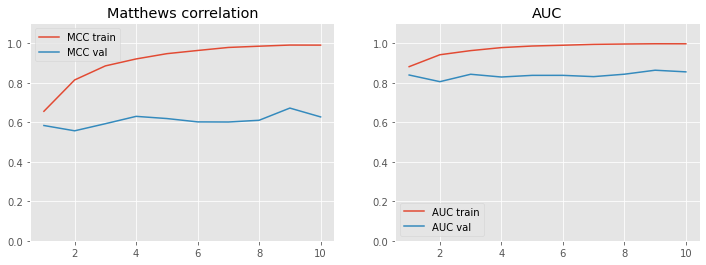

In [63]:
plot_training(history)

Apparent overfitting starting at about epoch 5. A quick search through plausible dropout/learning rates did not yield any stable improvements. 
The training dataset is very small, and one of the remedies to overfitting may be training on other sources of good/bad sentences. This is expressely permitted under the GLUE rules.

### Predict test (Kaggle)

From CoLA [Kaggle competition](https://www.kaggle.com/c/cola-in-domain-open-evaluation/overview) rules: 
- For submission you will have to generate a CSV with two columns, Id and Label where Id is same and Label is 0 or 1 depicting whether Sentence is grammatical or not.

In [64]:
test_df.head()

,Sentence
Id,
1,Bill whistled past the house.
2,The car honked its way down the road.
3,Bill pushed Harry off the sofa.
4,the kittens yawned awake and played.
5,"I demand that the more John eats, the more he ..."


In [65]:
# produce 3-part inputs for BERT from the test file
max_len=MAX_LEN

input_word_ids=[]
for sentence in test_df.iloc[:,-1]:
    input_word_ids.append(encode_sentence(sentence))
input_word_ids = pad_sequences(input_word_ids, maxlen=max_len, dtype="long", value=0, padding="post")
input_mask = np.vectorize(lambda arr: int(arr>0))(input_word_ids)
input_segment_ids = np.zeros_like(input_mask)
inputs = (input_word_ids, input_mask, input_segment_ids)


In [66]:
test_predictions = np.squeeze(model(inputs).numpy())
print(test_predictions.shape)
print(np.mean(np.round(test_predictions)))

(530,)
0.80566037


In [67]:
kaggle_df = pd.DataFrame({'Id': test_df.index, 'Label': np.round(test_predictions)}, dtype=int)
kaggle_df.head()

,Id,Label
0,1,1
1,2,1
2,3,1
3,4,1
4,5,0


In [68]:
kaggle_df.to_csv(path+f'cola_data/predictions/cola_{int(time.time())}.csv', index=False)

In [ ]:
# Submission file: cola_1595781677.csv
# Your submission scored 0.57044